IRIS CLASSIFICATION PROJECT

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import joblib

In [6]:
data = pd.read_csv(r'C:\Users\sekpu\Desktop\Teks 2024\All_data_sets\Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [9]:
data.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [10]:
data.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [11]:
if 'Id' in data.columns:
    data = data.drop(columns=['Id'])

In [12]:
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


NUMBER OF ROWS, COLUMNS, NULLS AND LABEL DISTRIBUTION

In [14]:
print('Shape:', data.shape)
print('\nNull values:\n', data.isnull().sum())
print('\nLabel counts:\n', data.iloc[:,-1].value_counts())

Shape: (150, 5)

Null values:
 SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Label counts:
 Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


SPLIT FEATURES AND TARGET VARIABLES 

In [16]:
X = data.iloc[:,:-1].copy()
y = data.iloc[:,-1].copy()

TRANSFORMING TARGET TO INTEGERS USING LABEL ENCODER

In [18]:
le = LabelEncoder()
y_encode = le.fit_transform(y)

print('Feature Columns:', X.columns.tolist())
print('Encoded Classes:', list(le.classes_))

Feature Columns: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
Encoded Classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


TRAIN/TEST SPLIT (STRATIFIED)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y_encode, test_size = 0.2, stratify = y_encode, random_state = 42)
print('Train shape, Test Shape:', X_train.shape, X_test.shape)

Train shape, Test Shape: (120, 4) (30, 4)


PIPELINE AND CROSS-VALIDATION

In [20]:
models = {
    'KNN' : Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True))]),
    'DecisionTree': Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier(random_state=42))])
}

In [22]:
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print(f'{name}: CV mean accuracy = {scores.mean():.4f} ± {scores.std():.4f}')

KNN: CV mean accuracy = 0.9667 ± 0.0312
SVM: CV mean accuracy = 0.9667 ± 0.0312
DecisionTree: CV mean accuracy = 0.9417 ± 0.0204


GRID SEARCH

In [23]:
parameter_grid = {
    'svc__C' : [0.1,1,10],
    'svc__gamma' : [0.01,0.1,1],
    'svc__kernel' : ['rbf']
}

In [25]:
svm_pipe = models['SVM']
gs = GridSearchCV(svm_pipe, parameter_grid, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params (SVM):', gs.best_params_)
print('Best CV score:', gs.best_score_)

Best params (SVM): {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best CV score: 0.975


TRAIN FINAL MODELS ON TRAINING SET

In [27]:
fitted = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f'{name} test accuracy: {acc:.4f}')
    print(classification_report(y_test, preds, target_names=le.classes_))
    fitted[name] = pipe

KNN test accuracy: 0.9333
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.80      0.89        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30

SVM test accuracy: 0.9667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

DecisionTree test accuracy: 0.9000
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00     

EVALUATING BEST SVM  FROM GRID SEARCH

In [28]:
best_svm = gs.best_estimator_
best_preds = best_svm.predict(X_test)
print('SVM (grid) test acc:', accuracy_score(y_test, best_preds))

SVM (grid) test acc: 0.9666666666666667


CONFUSION MATRIX FOR THE BEST POTENTIAL MODEL

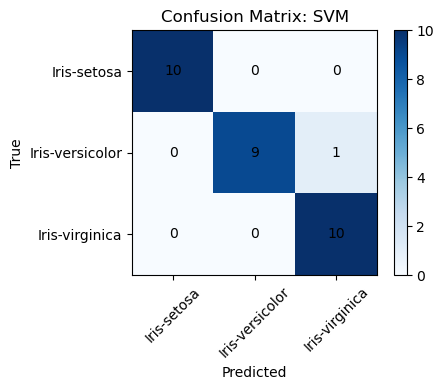

In [30]:
best_model_name = max(fitted.keys(), key=lambda k: accuracy_score(y_test, fitted[k].predict(X_test)))
best_model = fitted[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix: {best_model_name}')
plt.colorbar()
labels = le.classes_
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

PRINCIPAL COMPONENT ANALYSIS VISUALIZATION

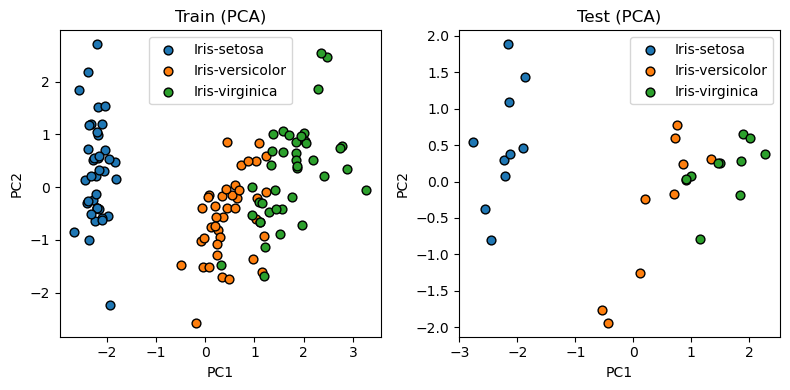

In [31]:
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

pca = PCA(n_components=2, random_state=42).fit(X_train_s)
Xtr_p = pca.transform(X_train_s)
Xte_p = pca.transform(X_test_s)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
for lab in np.unique(y_train):
    mask = y_train == lab
    plt.scatter(Xtr_p[mask,0], Xtr_p[mask,1], label=le.inverse_transform([lab])[0], s=40, edgecolor='k')
plt.title('Train (PCA)'); plt.legend(); plt.xlabel('PC1'); plt.ylabel('PC2')

plt.subplot(1,2,2)
for lab in np.unique(y_test):
    mask = y_test == lab
    plt.scatter(Xte_p[mask,0], Xte_p[mask,1], label=le.inverse_transform([lab])[0], s=40, edgecolor='k')
plt.title('Test (PCA)'); plt.legend(); plt.xlabel('PC1'); plt.ylabel('PC2')

plt.tight_layout()
plt.show()

PERMUTATION IMPORTANCE

C:\Users\sekpu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\sekpu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\sekpu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\sekpu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\sekpu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\sekpu\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid f

SepalLengthCm: 0.0000
SepalWidthCm: 0.0000
PetalLengthCm: 0.0000
PetalWidthCm: 0.0000


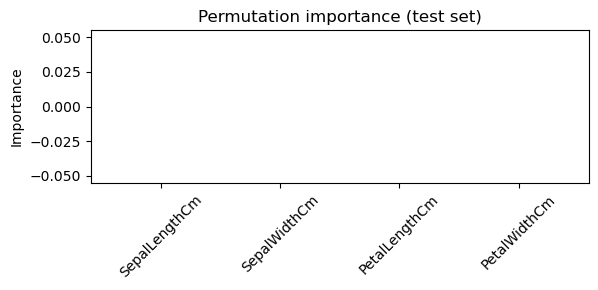

In [32]:
from sklearn.inspection import permutation_importance
res = permutation_importance(best_model, scaler.transform(X_test), y_test, n_repeats=30, random_state=42)
imp_means = res.importances_mean
for name, val in zip(X.columns, imp_means):
    print(f'{name}: {val:.4f}')

plt.figure(figsize=(6,3))
plt.bar(X.columns, imp_means)
plt.title('Permutation importance (test set)')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

|CONCLUSION|

Key Insights :-

-> Petal measurements are the most significant predictors

-> According to PCA plots and permutation importance, PetalLengthCm and PetalWidthCm distinctly differentiate the three species more effectively than sepal characteristics.

-> Models demonstrate exceptional performance on this dataset

-> KNN, SVM, and Decision Tree all reached high accuracy levels on the test set.

-> Cross-validation verified that the performance remains consistent across folds.

-> The optimized SVM (using GridSearchCV) outperformed the untuned models slightly.

-> SVM (RBF kernel) emerged as the top-performing model overall

-> Grid search identified the best values for C and gamma.

-> This model exhibited good generalization and provided the most reliable results.

-> PCA visualization indicated clear class separation

-> The first two principal components accounted for the majority of the variance.

-> Setosa created a completely distinct cluster.

-> Versicolor and Virginica showed minor overlap, which is anticipated.

-> Permutation importance clarified the influence of features

-> Petal-based features were the most significant contributors to model accuracy.

-> Sepal features provided additional supporting information but were less influential.